<a href="https://www.kaggle.com/code/lonnieqin/microbusiness-density-forecasting-with-prophet?scriptVersionId=114290967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Microbusiness Density Forecasting with Prophet
I this notebook, I will create models in [GoDaddy - Microbusiness Density Forecasting Competition](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting) using Prophet. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. You can find more details [here](https://facebook.github.io/prophet/).

## Install Prophet

In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


## Configuration

In [2]:
class Configuration:
    is_training = False
    model_base_path = "../input/godaddy-prophet-models/"
config = Configuration()

## Import packages

In [3]:
import numpy as np
import time
from prophet import Prophet
import pandas as pd
from prophet.serialize import model_to_json, model_from_json
from tqdm import tqdm

## Load data

In [4]:
train = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")
train.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257


The input to Prophet is always a dataframe with two columns: ds and y. ds should be date format that can be handled by pandas like YYYY-MM-DD, y is the target we want to predict, should be numeric. Also keep cfips to build models separated by different counties.

In [5]:
train_df = train[["first_day_of_month", "microbusiness_density", "cfips"]]
train_df.columns = ["ds", "y", "cfips"]
train_df.head()

,ds,y,cfips
0,2019-08-01,3.007682,1001
1,2019-09-01,2.884870,1001
2,2019-10-01,3.055843,1001
3,2019-11-01,2.993233,1001
4,2019-12-01,2.993233,1001


Load submission file,  in order to make prediction conveniently, add cfips and ds field.

In [6]:
submission = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv")
submission["microbusiness_density"] = 0
submission["cfips"] = submission["row_id"].apply(lambda row_id: int(row_id.split("_")[0]))
submission["ds"] = submission["row_id"].apply(lambda row_id: row_id.split("_")[-1])
submission.head()

,row_id,microbusiness_density,cfips,ds
0,1001_2022-11-01,0,1001,2022-11-01
1,1003_2022-11-01,0,1003,2022-11-01
2,1005_2022-11-01,0,1005,2022-11-01
3,1007_2022-11-01,0,1007,2022-11-01
4,1009_2022-11-01,0,1009,2022-11-01


Now use data from a single county as sample. Create a Prophet object and fit the model.

In [7]:
CFIPS = 1001
df = train_df[train_df.cfips == CFIPS]
m = Prophet(yearly_seasonality=10)
# Add country holiday
m.add_country_holidays(country_name='US')
m.fit(df)

07:52:43 - cmdstanpy - INFO - Chain [1] start processing
07:52:44 - cmdstanpy - INFO - Chain [1] done processing


Make forecast.

In [8]:
time_series =  pd.concat([
    train_df[train_df.cfips == CFIPS][["ds"]], 
    submission[submission.cfips == CFIPS][["ds"]]
])
forecast = m.predict(time_series)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-01,4.871012,2.941023,3.040633,4.871012,4.871012,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.880710,-1.880710,-1.880710,0.0,0.0,0.0,2.990303
1,2019-09-01,4.879021,2.844498,2.945753,4.879021,4.879021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.983826,-1.983826,-1.983826,0.0,0.0,0.0,2.895195
2,2019-10-01,4.886772,2.969349,3.071737,4.886772,4.886772,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.867967,-1.867967,-1.867967,0.0,0.0,0.0,3.018806
3,2019-11-01,4.894781,2.923304,3.025775,4.894781,4.894781,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.917571,-1.917571,-1.917571,0.0,0.0,0.0,2.977210
4,2019-12-01,4.902532,2.944669,3.046765,4.902532,4.902532,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.908243,-1.908243,-1.908243,0.0,0.0,0.0,2.994289


Plot the forecast.

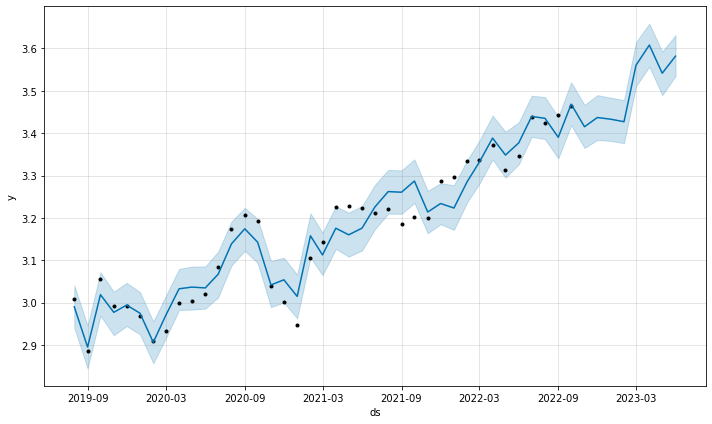

In [9]:
fig = m.plot(forecast)

Take a look at forecast components, You can see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

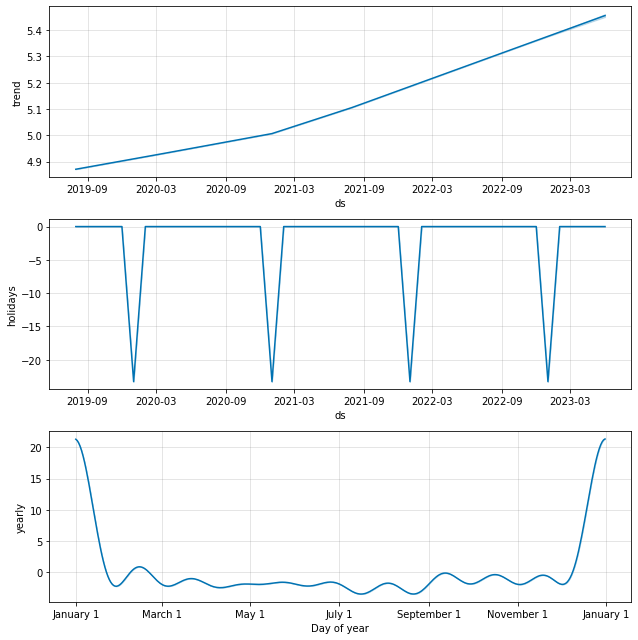

In [10]:
fig2 = m.plot_components(forecast)

Write prediction result to submission file.

In [11]:
submission.loc[submission.cfips == CFIPS, "microbusiness_density"] = list(m.predict(submission[submission.cfips == 1001])["yhat"])
submission[submission.cfips == CFIPS].head()

,row_id,microbusiness_density,cfips,ds
0,1001_2022-11-01,3.415171,1001,2022-11-01
3135,1001_2022-12-01,3.436954,1001,2022-12-01
6270,1001_2023-01-01,3.432986,1001,2023-01-01
9405,1001_2023-02-01,3.427059,1001,2023-02-01
12540,1001_2023-03-01,3.560372,1001,2023-03-01


Save the model. It's recommended to save the model to JSON format.

In [12]:
with open('1001.json', 'w') as fout:
    fout.write(model_to_json(m))

Load model from json file.

In [13]:
with open('1001.json', 'r') as fin:
    m = model_from_json(fin.read())

## Modeling

In [14]:
for cfips in tqdm(train_df.cfips.unique()):
    item = train_df[train_df.cfips == cfips]
    if config.is_training:
        m = Prophet(yearly_seasonality=10)
        ## add country holiday
        m.add_country_holidays(country_name='US')
        ## Fit the model
        m.fit(item)
        # Save the model
        with open(f'{cfips}.json', 'w') as fout:
            fout.write(model_to_json(m))
    else:
        # Load the model
        with open(f'{config.model_base_path}{cfips}.json', 'r') as fin:
            m = model_from_json(fin.read())
    # Make prediction
    submission.loc[submission.cfips == cfips, "microbusiness_density"] = list(m.predict(submission[submission.cfips == cfips])["yhat"])

100%|██████████| 3135/3135 [31:14<00:00,  1.67it/s]


## Create Submission file

In [15]:
submission[["row_id", "microbusiness_density"]].to_csv("submission.csv", index=False)
submission.head()

,row_id,microbusiness_density,cfips,ds
0,1001_2022-11-01,3.415171,1001,2022-11-01
1,1003_2022-11-01,8.507735,1003,2022-11-01
2,1005_2022-11-01,1.193393,1005,2022-11-01
3,1007_2022-11-01,1.313586,1007,2022-11-01
4,1009_2022-11-01,1.844632,1009,2022-11-01
